In [1]:
# CELL to import and set up matplotlib for the entire notebook
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams["savefig.dpi"] = 96
plt.rcParams["savefig.format"] = 'pdf'
plt.rcParams["figure.figsize"] = (6,6)
# %matplotlib notebook
%matplotlib widget

# Tension spring stiffness single parameter

In [1]:
from symulathon import Simulation
import numpy as np
from tqdm.notebook import tqdm
from simulation_functions import simulate
from concurrent import futures

In [6]:
sim = Simulation(1, 1)
nDoF = sim.getDoF()
mass = sim.getMassMatrix()
h = sim.getTimeStep()
DIFF_FRAMES = 100

k_values = np.linspace(0.01, 100, 800)
g_values = []
dgdp_values = []
# for k in tqdm(k_values):
#     bp = simulate(k, 0.1, DIFF_FRAMES)
#     g_values.append(bp.get_g())
#     dgdp_values.append(bp.get_dgdp()[0])
pool = futures.ProcessPoolExecutor(12)
def sim_wrapper(k):
    bp = simulate(k, 0.1, DIFF_FRAMES)
    g = bp.get_g()
    dgdp = bp.get_dgdp()[0]
    return (g, dgdp)

gdgdps = pool.map(sim_wrapper, k_values)
for gdgdp in tqdm(gdgdps,total=len(k_values)):
    g_values.append(gdgdp[0])
    dgdp_values.append(gdgdp[1])

# Calculate finite differences
dgdp_finite = []
for i in range(len(g_values)-1):
    value = (g_values[i+1]-g_values[i]) / (k_values[i+1] - k_values[i])
    dgdp_finite.append(value)
dgdp_finite.append(dgdp_finite[-1])

  0%|          | 0/800 [00:00<?, ?it/s]

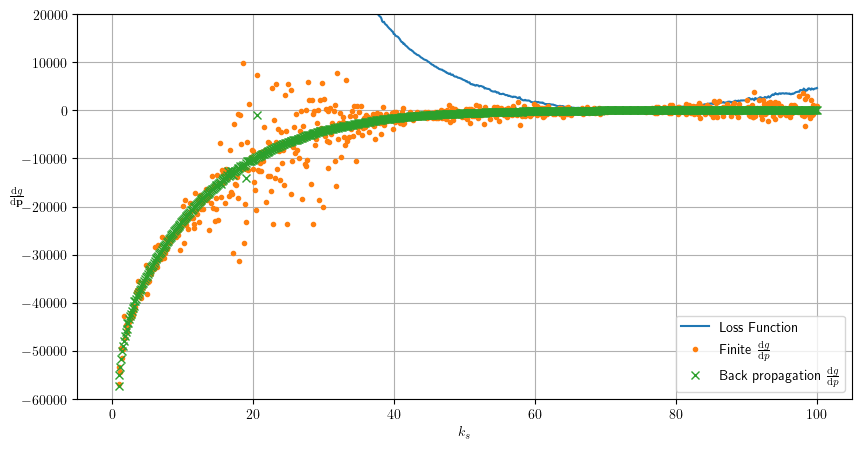

Finished succesfully


In [7]:
plt.rcParams["figure.figsize"] = (10,5)
plt.close()
plt.plot(k_values, g_values, "-", label="Loss Function")
plt.plot(k_values, dgdp_finite, ".", label="Finite $\\frac{\mathrm{d}g}{\mathrm{d}p}$")
plt.plot(k_values, dgdp_values, "x", label="Back propagation $\\frac{\mathrm{d}g}{\mathrm{d}p}$")
error = abs(np.array(dgdp_finite) - np.array(dgdp_values))
# plt.errorbar(k_values, dgdp_values, yerr = error)
plt.legend()
plt.xlabel("$k_s$")
plt.ylabel("$\\frac{\mathrm{d}g}{\mathrm{d}\mathbf{p}}$", rotation=0)
plt.ylim(-60000,20000)
plt.grid()
plt.show()
plt.savefig('figures/test.pdf')
print("Finished succesfully")

# Tilt angle single parameter

In [2]:
from symulathon import Simulation
from simulation_functions import newton_iteration
from recorder import SimulationReader
from backpropagation import Backpropagation
import numpy as np
from tqdm.notebook import tqdm
from concurrent import futures

In [3]:
k = 70
k_bend = 0.1
graphics=False
sim = Simulation(k, k_bend, 0, graphics)
DIFF_FRAMES = 100

def simulate(tilt_angle: float, diff_frames: int):
    nDoF = sim.getDoF()
    mass = sim.getMassMatrix()
    h = sim.getTimeStep()
    reader = SimulationReader(nDoF)
    sim.reset_simulation(k, k_bend, tilt_angle)
    dx0dp = sim.getInitialPositionJacobian()
    dv0dp = sim.getInitialVelocityJacobian()
    backpropagation = Backpropagation(mass, dx0dp, dv0dp, h)
    sim.fill_containers()
    for i in range(DIFF_FRAMES+1):
        ##################################
        # Record step for backpropagation
        ##################################
        x = sim.getPosition()
        v = sim.getVelocity()
        x_t, v_t = reader.get_next_state()
        A = sim.getEquationMatrix()
        dfdp = sim.getParameterJacobian()
        dfdx = sim.getForcePositionJacobian()
        backpropagation.step(x, v, x_t, v_t, A, dfdp, dfdx)

        ##################################
        # Newton Iterations
        ##################################
        iterations = 5
        xi = x
        vi = v
        for it in range(iterations):
            xi, vi = newton_iteration(sim, x, v, xi, vi)
            sim.set_state(xi, vi)
            sim.fill_containers()

        sim.render_state()
    return backpropagation


In [4]:
nDoF = sim.getDoF()
mass = sim.getMassMatrix()
h = sim.getTimeStep()

angle_values = np.linspace(0, 360, 300)
g_values = []
dgdp_values = []
def sim_wrapper(angle):
    bp = simulate(np.radians(angle), DIFF_FRAMES)
    g = bp.get_g()
    dgdp = bp.get_dgdp()[3]
    return g, dgdp

pool = futures.ProcessPoolExecutor()
gdgdps = pool.map(sim_wrapper, angle_values)
for gdgdp in tqdm(gdgdps,total=len(angle_values)):
    g_values.append(gdgdp[0])
    dgdp_values.append(gdgdp[1])
    
# for angle in tqdm(angle_values):
#     bp = simulate(np.radians(angle), DIFF_FRAMES)
#     g_values.append(bp.get_g())
#     dgdp_values.append(bp.get_dgdp()[3])

# Calculate finite differences
dgdp_finite = []
for i in range(len(g_values)-1):
    value = (g_values[i+1]-g_values[i]) / (angle_values[i+1] - angle_values[i])
    dgdp_finite.append(value)
dgdp_finite.append(dgdp_finite[-1])

  0%|          | 0/300 [00:00<?, ?it/s]

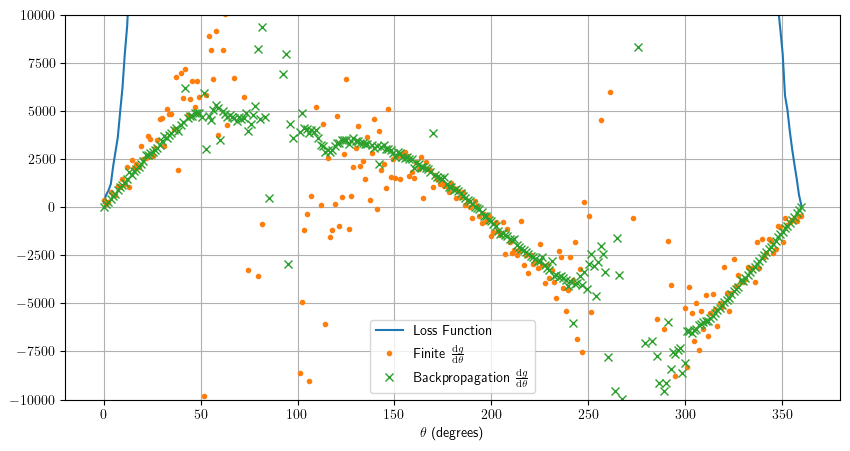

Finished succesfully


In [5]:
plt.rcParams["figure.figsize"] = (10,5)
plt.close()
plt.plot(angle_values, g_values, "-", label="Loss Function")
plt.plot(angle_values, dgdp_finite, ".", label="Finite $\\frac{\mathrm{d}g}{\mathrm{d}\\theta}$")
plt.plot(angle_values, dgdp_values, "x", label="Backpropagation $\\frac{\mathrm{d}g}{\mathrm{d}\\theta}$")

plt.legend()
plt.xlabel("$\\theta$ (degrees)")
plt.ylim(-10000,10000)
plt.xlim(-20,380)
plt.grid()
# plt.xticks(np.linspace(0,360,9))
plt.show()
plt.savefig("figures/test.pdf")
print("Finished succesfully")

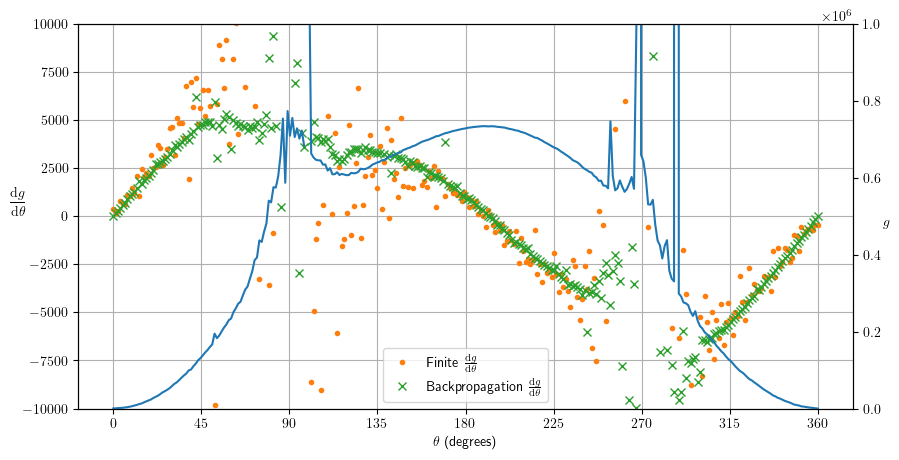

In [6]:
plt.close()
fig, ax1 = plt.subplots()

ax1.set_xlabel('$\\theta$ (degrees)')
ax1.set_ylabel("$\displaystyle\\frac{\mathrm{d}g}{\mathrm{d}\\theta}$", rotation=0)

ax1.plot(angle_values, dgdp_finite, ".",color = "#ff7f0e",
         label="Finite $\\frac{\mathrm{d}g}{\mathrm{d}\\theta}$")
ax1.plot(angle_values, dgdp_values, "x", color = "#2ca02c",
         label="Backpropagation $\\frac{\mathrm{d}g}{\mathrm{d}\\theta}$")
ax1.tick_params(axis='y')
ax1.set_ylim(-10000,10000)
ax1.set_xticks(np.linspace(0,360,9))
ax1.grid()
ax1.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('$\displaystyle g$', rotation=0)  # we already handled the x-label with ax1
ax2.plot(angle_values, g_values, "-", label="Loss Function")
ax2.set_ylim(0,1000000)
ax2.tick_params(axis='y')

# fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
plt.savefig("figures/test.pdf")

# Two diferential parameters: tension and bending spring stiffness

In [2]:
from symulathon import Simulation
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm.notebook import tqdm
from simulation_functions import simulate
from concurrent import futures

In [3]:
# Initialize important constant variables
sim = Simulation(1, 1)
nDoF = sim.getDoF()
mass = sim.getMassMatrix()
h = sim.getTimeStep()
DIFF_FRAMES = 100

# Define the region studied
n_points = 20
k_values = np.linspace(65, 75, n_points)
k_bend_values = np.linspace(0, 0.2, n_points)
X, Y = np.meshgrid(k_values, k_bend_values, indexing='ij')
g_values = np.zeros(X.shape)
dgdk_values = np.zeros(X.shape)
dgdk_bend_values = np.zeros(X.shape)

# Multi-core solution
pool = futures.ProcessPoolExecutor()
for i in tqdm(range(len(k_values))):
    k_values_i = [k_values[i]] * len(k_bend_values)
    DIFF_FRAMES_i = [DIFF_FRAMES] * len(k_bend_values)
    bps = pool.map(simulate, k_values_i, k_bend_values, DIFF_FRAMES_i)
    for j, bp in enumerate(bps):
        dgdp = bp.get_dgdp()
        dgdk_values[i][j] = dgdp[0]
        dgdk_bend_values[i][j] = dgdp[1]
        g_values[i][j] = bp.get_g()

  0%|          | 0/20 [00:00<?, ?it/s]

In [6]:
# Finite differences
X, Y = np.meshgrid(k_values, k_bend_values, indexing='ij')
dk = k_values[1]-k_values[0]
dk_bend = k_bend_values[1]-k_bend_values[0]
g_values = np.array(g_values)
dgdk_values_finite, dgdk_bend_values_finite = np.gradient(g_values, dk, dk_bend)

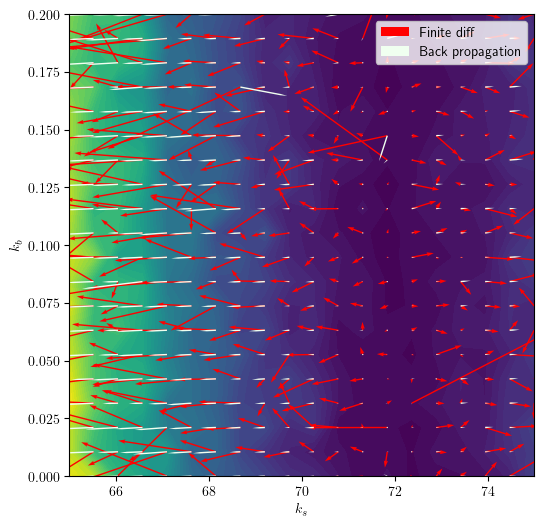

In [7]:
plt.close()

scale = (k_values[-1] - k_values[0]) / (k_bend_values[-1] - k_bend_values[0])

norm = np.sqrt((dgdk_values)**2 + (dgdk_bend_values)**2)
# norm=1
scaled_norm = np.sqrt((dgdk_values*scale)**2 + (dgdk_bend_values)**2)
factor = norm / scaled_norm

dgdk_values_n = dgdk_values*scale*factor
dgdk_bend_values_n =dgdk_bend_values*factor
dgdk_values_finite_n = dgdk_values_finite*scale*factor
dgdk_bend_values_finite_n =dgdk_bend_values_finite*factor

arrow_len=300
plt.contourf(X, Y, g_values, levels=50)
plt.quiver(X, Y, dgdk_values_finite_n, dgdk_bend_values_finite_n/scale,
           label="Finite diff",
           angles='xy',
           scale_units="xy",
           color="red",
           scale=arrow_len)
plt.quiver(X, Y, dgdk_values_n, dgdk_bend_values_n/scale,
           label="Back propagation",
           angles='xy',
           scale_units="xy",
           color="honeydew",
           headwidth=1,
           scale=arrow_len)

plt.legend(loc='upper right')
plt.xlabel("$k_s$")
plt.ylabel("$k_b$")
plt.show()
plt.savefig("figures/test.pdf")

In [ ]:
print(np.mean(dgdk_values - dgdk_values_finite), np.var(dgdk_values - dgdk_values_finite))
print(np.mean(dgdk_bend_values - dgdk_bend_values_finite), np.var(dgdk_bend_values - dgdk_bend_values_finite))

In [ ]:
# Plotting
plt.close()

scale = (k_values[-1] - k_values[0]) / (k_bend_values[-1] - k_bend_values[0])
arrow_len=None
plt.contourf(X, Y, g_values, levels=60)
plt.quiver(X, Y, dgdk_values_finite*scale, dgdk_bend_values_finite,
           label="Finite diff",
           angles='xy',
           scale_units="xy",
           color="red",
           scale=arrow_len)
plt.quiver(X, Y, dgdk_values*scale, dgdk_bend_values,
           label="Back propagation",
           angles='xy',
           scale_units="xy",
           color="honeydew",
           # alpha=0.7,
           headwidth=1,
           scale=arrow_len)

plt.legend()
plt.xlabel("$k_s$")
plt.ylabel("$k_b$")
plt.show()
plt.savefig("figures/test.pdf")

In [ ]:
# save the data to disk
np.save("data/x_data.npy", X)
np.save("data/y_data.npy", Y)
np.save("data/g_data.npy", g_values)
np.savez("data/dgdk_data.npy",
         dgdk_values,
         dgdk_bend_values,
         dgdk_values_finite,
         dgdk_bend_values_finite)

# Two different parameters: Angle and stiffness

In [2]:
from symulathon import Simulation
from simulation_functions import newton_iteration
from recorder import SimulationReader
from backpropagation import Backpropagation
import numpy as np
from tqdm.notebook import tqdm
from concurrent import futures

In [3]:
k_bend = 0.1
sim = Simulation(20, k_bend, 0, False)
DIFF_FRAMES = 100

def simulate(k: float, tilt_angle: float, diff_frames: int):
    nDoF = sim.getDoF()
    mass = sim.getMassMatrix()
    h = sim.getTimeStep()
    reader = SimulationReader(nDoF)
    sim.reset_simulation(k, k_bend, tilt_angle)
    dx0dp = sim.getInitialPositionJacobian()
    dv0dp = sim.getInitialVelocityJacobian()
    backpropagation = Backpropagation(mass, dx0dp, dv0dp, h)
    sim.fill_containers()
    # print(sim.getDiffParameters())
    for i in range(DIFF_FRAMES+1):
        ##################################
        # Record step for backpropagation
        ##################################
        x = sim.getPosition()
        v = sim.getVelocity()
        x_t, v_t = reader.get_next_state()
        A = sim.getEquationMatrix()
        dfdp = sim.getParameterJacobian()
        dfdx = sim.getForcePositionJacobian()
        backpropagation.step(x, v, x_t, v_t, A, dfdp, dfdx)

        ##################################
        # Newton Iterations
        ##################################
        iterations = 3
        xi = x
        vi = v
        for it in range(iterations):
            xi, vi = newton_iteration(sim, x, v, xi, vi)
            sim.set_state(xi, vi)
            sim.fill_containers()

        sim.render_state()
    return backpropagation

In [43]:
# Initialize important constant variables
nDoF = sim.getDoF()
mass = sim.getMassMatrix()
h = sim.getTimeStep()
DIFF_FRAMES = 100

# Define the region studied
n_points = 15
k_values = np.linspace(60, 80, n_points)
angle_values = np.linspace(-50, 50, n_points)
X, Y = np.meshgrid(k_values, angle_values, indexing='ij')
g_values = np.zeros(X.shape)
dgdk_values = np.zeros(X.shape)
dgdangle_values = np.zeros(X.shape)

#Multi-core solution
pool = futures.ProcessPoolExecutor()
for i in tqdm(range(len(k_values))):
    k_values_i = [k_values[i]] * len(angle_values)
    DIFF_FRAMES_i = [DIFF_FRAMES] * len(angle_values)
    bps = pool.map(simulate, k_values_i, np.radians(angle_values), DIFF_FRAMES_i)
    for j, bp in enumerate(bps):
        dgdp = bp.get_dgdp()
        dgdk_values[i][j] = dgdp[0]
        dgdangle_values[i][j] = dgdp[3]
        g_values[i][j] = bp.get_g()

  0%|          | 0/15 [00:00<?, ?it/s]

In [44]:
# Finite differences
X, Y = np.meshgrid(k_values, angle_values, indexing='ij')
dk = k_values[1]-k_values[0]
dangle = angle_values[1]-angle_values[0]
g_values = np.array(g_values)
dgdk_values_finite, dgdangle_values_finite = np.gradient(g_values, dk, dangle)

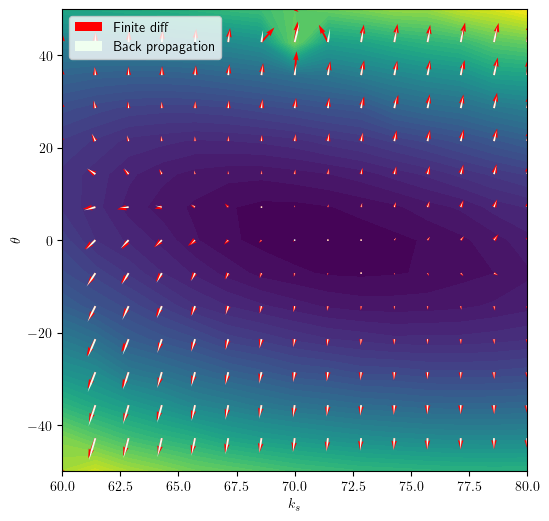

In [46]:
plt.close()

scale = (k_values[-1] - k_values[0]) / (angle_values[-1] - angle_values[0])

norm = np.sqrt((dgdk_values)**2 + (dgdangle_values)**2)
# norm=1
scaled_norm = np.sqrt((dgdk_values*scale)**2 + (dgdangle_values)**2)
factor = norm / scaled_norm

dgdk_values_n = dgdk_values*scale*factor
dgdangle_values_n =dgdangle_values*factor
dgdk_values_finite_n = dgdk_values_finite*scale*factor
dgdangle_values_finite_n =dgdangle_values_finite*factor

arrow_len=10000
plt.contourf(X, Y, g_values, levels=50)
plt.quiver(X, Y, dgdk_values_finite_n, dgdangle_values_finite_n/scale,
           label="Finite diff",
           angles='xy',
           scale_units="xy",
           color="red",
           scale=arrow_len)
plt.quiver(X, Y, dgdk_values_n, dgdangle_values_n/scale,
           label="Back propagation",
           angles='xy',
           scale_units="xy",
           color="honeydew",
           headwidth=1,
           scale=arrow_len)

plt.legend(loc="upper left")
plt.xlabel("$k_s$")
plt.ylabel("$\\theta$")
plt.show()
plt.savefig("figures/test.pdf")

# Multiple stiffness parameters

In [2]:
from symulathon import Simulation
from simulation_functions import newton_iteration
from recorder import SimulationReader
from backpropagation import Backpropagation
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from concurrent import futures

In [3]:
# Compute the number of springs for a NxM grid
k = 20
k_bend = 0.1
graphics=False
sim = Simulation(k, k_bend, 0, graphics)
DIFF_FRAMES = 100

def compute_tension_springs(N, M):
    return (M-1)*(N-1) + N*(M-1) + M*(N-1)
def compute_bending_springs(N, M):
    return (M-1)*(N-1) + (N-2)*(M-1) + (M-2)*(N-1)

N, M = sim.getGridDimensions()
n_tension = compute_tension_springs(N,M)
n_bending = compute_bending_springs(N,M)
print(f"The grid is {N}x{M} meaning it has {n_tension} tension springs, {n_bending} bend springs which add up to a total of {n_bending + n_tension} springs.")

The grid is 20x20 meaning it has 1121 tension springs, 1045 bend springs which add up to a total of 2166 springs.


In [4]:
tension_stiffness = np.array([k]*n_tension)
tension_stiffness = np.linspace(1.0, 1121.0, 1121)
# print(len(np.linspace(1.0,1121.0,1121)))
bending_stiffness = np.array([k_bend]*n_bending)
graphics = False
sim = Simulation(tension_stiffness, bending_stiffness, graphics)

In [5]:
def simulate(stiffness_array: np.array, bend_stiffness_array: np.array, diff_frames: int):
    nDoF = sim.getDoF()
    mass = sim.getMassMatrix()
    h = sim.getTimeStep()
    reader = SimulationReader(nDoF)
    sim.reset_simulation(stiffness_array, bend_stiffness_array)
    dx0dp = sim.getInitialPositionJacobian()
    dv0dp = sim.getInitialVelocityJacobian()
    backpropagation = Backpropagation(mass, dx0dp, dv0dp, h)
    sim.fill_containers()
    for i in range(DIFF_FRAMES+1):
        ##################################
        # Record step for backpropagation
        ##################################
        x = sim.getPosition()
        v = sim.getVelocity()
        x_t, v_t = reader.get_next_state()
        A = sim.getEquationMatrix()
        dfdp = sim.getParameterJacobian()
        dfdx = sim.getForcePositionJacobian()
        backpropagation.step(x, v, x_t, v_t, A, dfdp, dfdx)

        ##################################
        # Newton Iterations
        ##################################
        iterations = 2
        xi = x
        vi = v
        for it in range(iterations):
            xi, vi = newton_iteration(sim, x, v, xi, vi)
            sim.set_state(xi, vi)
            sim.fill_containers()

        sim.render_state()
    return backpropagation

In [10]:
k = 40.0
k_bend = 0.1
DIFF_FRAMES = 50

tension_stiffness = np.array([k]*n_tension)
bending_stiffness = np.array([k_bend]*n_bending)
bp = simulate(tension_stiffness, bending_stiffness, DIFF_FRAMES)
dgdp = bp.get_dgdp()[:-1] # the last parameter is garbage
g_base = bp.get_g()
dgdp.shape

(2166,)

In [11]:
tension_stiffness = np.array([k]*n_tension)
parameter_index = 30
dk = 0.1
tension_stiffness[parameter_index] += dk
bending_stiffness = np.array([k_bend]*n_bending)
bp = simulate(tension_stiffness, bending_stiffness, DIFF_FRAMES)
dgdp = bp.get_dgdp()[:-1] # the last parameter is garbage
print(f"g base = {g_base}\t g new = {bp.get_g()}")
print("{:.10f}".format(dgdp[parameter_index]))
print("{:.10f}".format((bp.get_g() - g_base) / dk))

g base = 1155.8944245791813	 g new = 1155.9098758004875
0.1556442200
0.1545122131


In [12]:
stiffness = np.concatenate((tension_stiffness, bending_stiffness))
n_stiffness = len(stiffness)
bp = simulate(tension_stiffness, bending_stiffness, DIFF_FRAMES)
g_base = bp.get_g()
dgdp = bp.get_dgdp()[:-1] # the last parameter is garbage
DK = 0.1

dg = np.array([0.]*n_stiffness)

DIFF_FRAMES_i = [DIFF_FRAMES]*n_stiffness
stiffness_i = [stiffness.copy() for i in range(n_stiffness)]
for i in range(n_stiffness):
    stiffness_i[i][i] += DK
    
def finite_simulate(stiffness: np.array):
    bp = simulate(stiffness[:len(tension_stiffness)].copy(), stiffness[len(tension_stiffness):].copy(), DIFF_FRAMES)
    return bp.get_g()

g_base = finite_simulate(stiffness)
for i in tqdm(range(n_stiffness)):
    dg[i] = finite_simulate(stiffness_i[i])

  0%|          | 0/2166 [00:00<?, ?it/s]

In [ ]:
pool = futures.ProcessPoolExecutor(4)
bps = pool.map(finite_simulate, stiffness_i)
dg = np.array(list(bps))
dgdp_finite = (np.array([g_base]*n_stiffness) - dg) / DK

In [13]:
dgdp_finite = (dg - np.array([g_base]*n_stiffness)) / DK
print(g_base)
print(dg)

1155.9098758004875
[1156.54916419 1156.55964399 1156.12898192 ... 1155.91034407 1155.90998242
 1155.91012175]


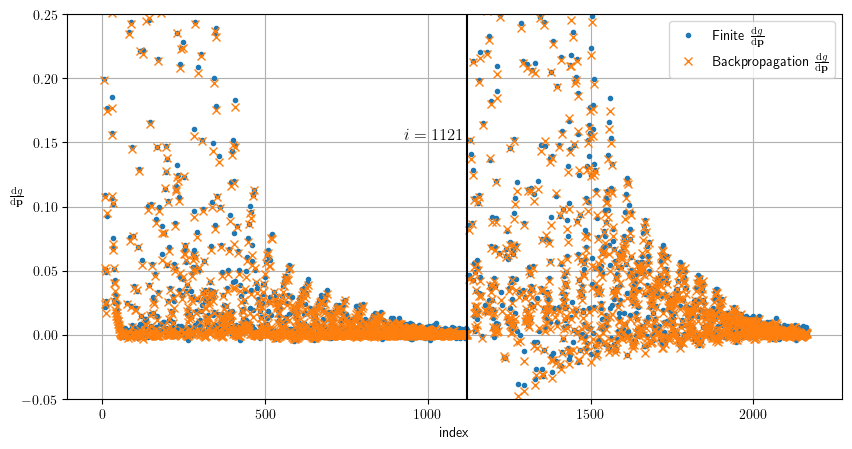

In [30]:
plt.close()
plt.rcParams["figure.figsize"] = (10,5)
x = np.arange(0,len(dgdp), 1)
plt.plot(x, dgdp_finite, ".", label="Finite $\\frac{\mathrm{d}g}{\mathrm{d}\mathbf{p}}$")
plt.plot(x, dgdp, "x", label="Backpropagation $\\frac{\mathrm{d}g}{\mathrm{d}\mathbf{p}}$")
# plt.errorbar(x, dgdp, abs(dgdp_finite - dgdp),fmt='none' )
x1, y1 = [1121, -10], [1121, 10]
plt.axline(x1, y1, color="black")
plt.xlabel("index")
plt.ylabel("$\\frac{\mathrm{d}g}{\mathrm{d}\mathbf{p}}$", rotation=0)
plt.grid()
plt.legend()
plt.ylim(-0.05,0.25)
plt.text(1110, 0.15, '$i=1121$  ',
        verticalalignment='bottom', horizontalalignment='right', fontsize=12)
plt.savefig("figures/multiple_dimensions_gradient.pdf")
plt.show()

In [ ]:
plt.close()
x = np.arange(0,len(dgdp), 1)
plt.show()

# Minimization process

In [1]:
from symulathon import Simulation
import numpy as np
from tqdm.notebook import tqdm
from scipy.optimize import minimize, Bounds
from simulation_functions import newton_iteration
from recorder import SimulationReader
from backpropagation import Backpropagation

In [2]:
from simulation_functions import simulate


## Tension stiffness minimization

In [3]:
sim = Simulation(1, 1)
nDoF = sim.getDoF()
mass = sim.getMassMatrix()
h = sim.getTimeStep()
DIFF_FRAMES = 100
n_tension, n_bending = sim.getSpringNumbers()

def simulation_wrapper(k_tension: float):
    print(k_tension)
    k_tension = max(1, k_tension)
    bp = simulate(k_tension, 0.1, DIFF_FRAMES)
    g = bp.get_g()
    dgdp = bp.get_dgdp()[0]
    return g, dgdp

In [5]:
k0 = 20
res = minimize(simulation_wrapper, k0, jac=True,
               bounds=Bounds(1, 150),
               options={"disp": True,
                        "maxiter": 100,
                       })
print(res)
print(res.x)

[20.]
[150.]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.49502D+04    |proj g|=  1.30000D+02
[148.29768826]

At iterate    1    f=  9.50710D+03    |proj g|=  6.55648D+01
[149.97380136]
[149.99997965]
[150.]
[150.]
[149.99998982]
[150.]
[150.]
[149.99999491]
[149.99999893]
[149.99999977]
[149.99999995]
[149.99999999]
[150.]
[150.]
[150.]
[150.]
[150.]
[150.]
[150.]
[84.43519907]



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


[1.]

At iterate    2    f=  1.10668D+03    |proj g|=  5.13383D+01
[59.71307191]
[69.38142146]

At iterate    3    f=  4.54758D+02    |proj g|=  3.29722D+01
[67.01539935]

At iterate    4    f=  1.08823D+02    |proj g|=  1.06833D+01
[69.19875091]
[68.66610317]
At iterate    5    f=  8.06838D+01    |proj g|=  7.95512D+00

[69.19806158]
[69.19728904]
[69.19806152]
[69.19806147]
[69.19767525]
[69.19806135]
[69.19806123]
[69.19786824]
[69.1980612]
[69.19806117]
[69.19796471]
[69.19806117]
[69.19806117]
[69.19801294]
[69.19806117]
[68.59917531]

At iterate    6    f=  8.06017D+01    |proj g|=  8.94438D+00
  ys=-6.823E-04  -gs= 5.487E-03 BFGS update SKIPPED
[69.19475863]
[69.19806032]
[69.19806099]
[69.19806113]
[69.19806116]
[69.19806116]
[69.19806117]
[69.19806117]
[69.19806117]
[69.19806117]
[69.19806117]
[69.19806117]
[69.19806117]
[69.19806117]
[69.19806117]
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 80.6016725130111
        x: [ 6


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [13]:
k0 = 20
lr = 0.01
for i in range(100):
    g, dgdp = simulation_wrapper(k0)
    k0 -= lr*dgdp
    print(k0)

20
122.52819556402
122.52819556402
121.56326280678162
121.56326280678162
120.64686881117974
120.64686881117974
119.64627787774121
119.64627787774121
118.6273316658078
118.6273316658078
117.6534386131057
117.6534386131057
116.59990439578954
116.59990439578954
115.58900287258
115.58900287258
114.55595416909705
114.55595416909705
113.54102842090421
113.54102842090421
112.53115601895689
112.53115601895689
111.4697053803513
111.4697053803513
110.51988441657078
110.51988441657078
109.4734202470634
109.4734202470634
108.32047224223237
108.32047224223237
107.26225545657195
107.26225545657195
106.21961165822522
106.21961165822522
105.27635045696512
105.27635045696512
104.282318710722
104.282318710722
103.15845056184986
103.15845056184986
102.09033352968086
102.09033352968086
100.992029772765
100.992029772765
99.79200621418518
99.79200621418518
98.73714289215148
98.73714289215148
97.70917614698831
97.70917614698831
96.64113214231337
96.64113214231337
95.82340814701355
95.82340814701355
94.940957

## Multiple stiffness minimization

In [3]:
sim = Simulation(1, 1)
nDoF = sim.getDoF()
mass = sim.getMassMatrix()
h = sim.getTimeStep()
DIFF_FRAMES = 100
n_tension, n_bending = sim.getSpringNumbers()

k_list = np.random.randint(10.0, 30.0, n_tension).astype(float)
k_bend_list = np.ones(n_bending) * 0.1
parameters = np.concatenate((k_list, k_bend_list))

def simulation_wrapper(k_list: float):
    bp = simulate(k_list[:n_tension], k_list[n_tension:], DIFF_FRAMES)
    g = bp.get_g()
    dgdp = bp.get_dgdp()[:-1]
    return g, dgdp

In [4]:
res = minimize(simulation_wrapper, parameters, jac=True,
               bounds=Bounds(1, 100),
               options={"disp": True,
                        "maxiter": 500,
                       })
print(res)
print(res.x)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         2166     M =           10

At X0      1045 variables are exactly at the bounds

At iterate    0    f=  1.80380D+05    |proj g|=  9.90000D+01

At iterate    1    f=  1.00070D+04    |proj g|=  3.95564D+00

At iterate    2    f=  9.98456D+03    |proj g|=  3.97957D+00

At iterate    3    f=  9.35471D+03    |proj g|=  4.74687D+00
  ys=-1.755E+02  -gs= 5.486E+02 BFGS update SKIPPED

At iterate    4    f=  9.05363D+03    |proj g|=  5.06408D+00
  ys=-3.812E+01  -gs= 2.809E+02 BFGS update SKIPPED

At iterate    5    f=  8.83357D+03    |proj g|=  5.30875D+00
  ys=-1.702E+01  -gs= 2.121E+02 BFGS update SKIPPED

At iterate    6    f=  8.60914D+03    |proj g|=  5.52009D+00
  ys=-1.689E+01  -gs= 2.168E+02 BFGS update SKIPPED

At iterate    7    f=  8.39720D+03    |proj g|=  5.73627D+00
  ys=-1.586E+01  -gs= 2.043E+02 BFGS update SKIPPED

At iterate    8    f=  8.20865D+03    |proj g|=  5.94504D+00
  ys=-1.235E+01


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   83    f=  1.85722D+01    |proj g|=  1.78526D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 2166     83    153    311    30    38   1.785D+00   1.857D+01
  F =   18.572237397910786     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [5]:
x_result = res.x
print(x_result)
stretch_res = x_result[:n_tension]
bend_res = x_result[n_tension:]
print(f"TENSION: mean value = {np.mean(stretch_res)}, var = {np.var(stretch_res)}")
print(f"BENDING: mean value = {np.mean(bend_res)}, var = {np.var(bend_res)}")


[17.16905413 16.87715472 61.71312606 ...  3.69779404 10.6290768
  2.40821059]
TENSION: mean value = 21.224822090179455, var = 83.67023496537642
BENDING: mean value = 6.685749132152834, var = 135.50153793604696


In [7]:
g_results = []

In [ ]:
lr = 0.05
last_value = 10000000000
last_paramters = parameters.copy()
last_dgdp = np.zeros(len(parameters))
for i in tqdm(range(300)):
    g, dgdp = simulation_wrapper(parameters)
    if not last_value > g:
        print("line search bad direction")
        last_dgdp /=2
        parameters = last_paramters.copy() - lr * last_dgdp
        continue
    last_value = g
    last_paramters = parameters.copy()
    last_dgdp = dgdp.copy()
    parameters -= lr*dgdp
    g_results.append(g)
    print(i, g)

In [ ]:
stretch_res = parameters[:n_tension]
bend_res = parameters[n_tension:]
print(f"TENSION: mean value = {np.mean(stretch_res)}, var = {np.var(stretch_res)}")
print(f"BENDING: mean value = {np.mean(bend_res)}, var = {np.var(bend_res)}")

In [46]:
g_lr0_01 = g_results.copy()

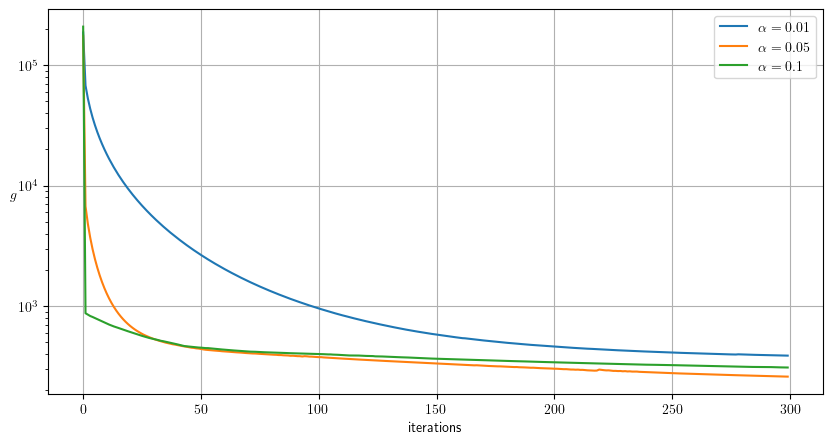

In [47]:
plt.rcParams["figure.figsize"] = (10,5)
plt.close()
plt.plot(g_lr0_001[:300], label="$\\alpha = 0.01$")
plt.plot(g_lr0_005[:300], label="$\\alpha = 0.05$")
plt.plot(g_lr0_01[:300], label="$\\alpha = 0.1$")
plt.xlabel("iterations")
plt.ylabel("$g$", rotation = 0)
plt.grid()
plt.yscale('log')
plt.legend()
plt.show()
plt.savefig("figures/test2.pdf")

## Angle minimization

In [2]:
k = 70
k_bend = 0.1
graphics=False
sim = Simulation(k, k_bend, 0, graphics)
DIFF_FRAMES = 100

def simulate(tilt_angle: float, diff_frames: int):
    nDoF = sim.getDoF()
    mass = sim.getMassMatrix()
    h = sim.getTimeStep()
    reader = SimulationReader(nDoF)
    sim.reset_simulation(k, k_bend, tilt_angle)
    dx0dp = sim.getInitialPositionJacobian()
    dv0dp = sim.getInitialVelocityJacobian()
    backpropagation = Backpropagation(mass, dx0dp, dv0dp, h)
    sim.fill_containers()
    for i in range(DIFF_FRAMES+1):
        ##################################
        # Record step for backpropagation
        ##################################
        x = sim.getPosition()
        v = sim.getVelocity()
        x_t, v_t = reader.get_next_state()
        A = sim.getEquationMatrix()
        dfdp = sim.getParameterJacobian()
        dfdx = sim.getForcePositionJacobian()
        backpropagation.step(x, v, x_t, v_t, A, dfdp, dfdx)

        ##################################
        # Newton Iterations
        ##################################
        iterations = 5
        xi = x
        vi = v
        for it in range(iterations):
            xi, vi = newton_iteration(sim, x, v, xi, vi)
            sim.set_state(xi, vi)
            sim.fill_containers()

        sim.render_state()
    return backpropagation


In [3]:
def simulation_wrapper(angle):
    angle = angle[0]
    bp = simulate(np.radians(angle), DIFF_FRAMES)
    g = bp.get_g()
    dgdp = bp.get_dgdp()[3]
    return g, dgdp

initial_angle = [180]
simulation_wrapper(initial_angle)

(727724.8322280025, 1004.6307488332455)

In [4]:
res = minimize(simulation_wrapper, initial_angle, jac=True,
               bounds=Bounds(-180, 400),
               method = "L-BFGS-B",
               options={"disp": True,
                        "maxiter": 500,
                       })
print(res)
print(res.x)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.27725D+05    |proj g|=  3.60000D+02

At iterate    1    f=  4.21747D+02    |proj g|=  2.05708D+02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    2    f=  3.30820D+02    |proj g|=  1.58867D+02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    3    f=  3.05759D+02    |proj g|=  1.47547D+02
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 305.7589348382378
        x: [-9.475e-01]
      nit: 4
      jac: [-1.475e+02]
     nfev: 75
     njev: 75
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
[-0.94745656]

At iterate    4    f=  3.05759D+02    |proj g|=  1.47547D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      4     75      6     0     0   1.475D+02   3.058D+02
  F =   305.75893483823779     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [5]:
g_results = []

In [8]:
lr = 0.1
last_value = 10000000000
last_angle = initial_angle.copy()
last_dgdp = 0
for i in tqdm(range(300)):
    g, dgdp = simulation_wrapper(initial_angle)
    if not last_value > g:
        print("line search bad direction")
        last_dgdp /=2
        parameters = initial_angle.copy() - lr * last_dgdp
        continue
    last_value = g
    last_angle = initial_angle.copy()
    last_dgdp = dgdp.copy()
    initial_angle -= lr*dgdp
    g_results.append(g)
    print(i, g)

  0%|          | 0/300 [00:00<?, ?it/s]

0 662353.3153784404
line search bad direction
line search bad direction
line search bad direction
line search bad direction


KeyboardInterrupt: 

# Testing scenarios

In [3]:
from symulathon import Simulation
import numpy as np
from tqdm.notebook import tqdm
from scipy.optimize import minimize, Bounds
from simulation_functions import newton_iteration
from recorder import SimulationReader
from backpropagation import Backpropagation
from time import sleep

In [4]:
sleep(2)
k = 100
k_bend = 0.1
graphics=True
sim = Simulation(k, k_bend, 0, graphics)
nDoF = sim.getDoF()
DIFF_FRAMES = 100

def simulate(initial_velocities: np.array, diff_frames: int):
    nDoF = sim.getDoF()
    mass = sim.getMassMatrix()
    h = sim.getTimeStep()
    reader = SimulationReader(nDoF,"record_shape.csv")
    sim.reset_simulation(initial_velocities)
    dx0dp = sim.getInitialPositionJacobian()
    dv0dp = sim.getInitialVelocityJacobian()
    backpropagation = Backpropagation(mass, dx0dp, dv0dp, h)
    sim.fill_containers()
    for i in range(DIFF_FRAMES+1):
        ##################################
        # Record step for backpropagation
        ##################################
        x = sim.getPosition()
        v = sim.getVelocity()
        x_t, v_t = reader.get_next_state()
        A = sim.getEquationMatrix()
        dfdp = sim.getParameterJacobian()
        dfdx = sim.getForcePositionJacobian()
        backpropagation.step(x, v, x_t, v_t, A, dfdp, dfdx)

        ##################################
        # Newton Iterations
        ##################################
        iterations = 3
        xi = x
        vi = v
        for it in range(iterations):
            xi, vi = newton_iteration(sim, x, v, xi, vi)
            sim.set_state(xi, vi)
            sim.fill_containers()

        sim.render_state()
    return backpropagation
    
def simulate2(k: float, k_bend: float, initial_velocities: np.array, diff_frames: int):
    nDoF = sim.getDoF()
    mass = sim.getMassMatrix()
    h = sim.getTimeStep()
    reader = SimulationReader(nDoF,"record_shape.csv")
    sim.reset_simulation(k, k_bend, initial_velocities)
    dx0dp = sim.getInitialPositionJacobian()
    dv0dp = sim.getInitialVelocityJacobian()
    print(dv0dp.shape)
    backpropagation = Backpropagation(mass, dx0dp, dv0dp, h)
    sim.fill_containers()
    for i in range(DIFF_FRAMES+1):
        ##################################
        # Record step for backpropagation
        ##################################
        x = sim.getPosition()
        v = sim.getVelocity()
        x_t, v_t = reader.get_next_state()
        A = sim.getEquationMatrix()
        dfdp = sim.getParameterJacobian()
        dfdx = sim.getForcePositionJacobian()
        backpropagation.step(x, v, x_t, v_t, A, dfdp, dfdx)

        ##################################
        # Newton Iterations
        ##################################
        iterations = 3
        xi = x
        vi = v
        for it in range(iterations):
            xi, vi = newton_iteration(sim, x, v, xi, vi)
            sim.set_state(xi, vi)
            sim.fill_containers()

        sim.render_state()
    return backpropagation

In [5]:
initial_velocities = np.zeros(nDoF)
initial_tension = np.array([100])
initial_bending = np.array([0.1])
parameters = np.concatenate((initial_tension, initial_bending, initial_velocities))
print(parameters)

[100.    0.1   0.  ...   0.    0.    0. ]


In [6]:
def simulation_wrapper(initial_velocities):
    bp = simulate2(100, 1, initial_velocities, DIFF_FRAMES)
    g = bp.get_g()
    dgdp = bp.get_dgdp()[3:]
    return g, dgdp

def simulation_wrapper2(paramters):
    k = paramters[0]
    k_bend = paramters[1]
    ivel = paramters[2:]
    bp = simulate2(k, k_bend, ivel, DIFF_FRAMES)
    g = bp.get_g()
    dgdp = bp.get_dgdp()
    dgdp = np.delete(dgdp, 2) # remove garbage paramter
    return g, dgdp

In [ ]:
print(len(initial_velocities))
res = minimize(simulation_wrapper2, parameters, jac=True,
               bounds=Bounds(-100, 100),
               options={"disp": True,
                        "maxiter": 500,
                       })
print(res)
print(res.x)

1200
(1200, 1203)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1202     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  1.71674D+06    |proj g|=  1.00000D+02
(1200, 1203)
(1200, 1203)

At iterate    1    f=  6.38346D+02    |proj g|=  1.62528D+01
(1200, 1203)
(1200, 1203)
(1200, 1203)

At iterate    2    f=  1.28673D+01    |proj g|=  2.70774D+01
(1200, 1203)
(1200, 1203)
(1200, 1203)
(1200, 1203)
(1200, 1203)

At iterate    3    f=  1.28431D+01    |proj g|=  1.46202D+01
(1200, 1203)

At iterate    4    f=  1.28054D+01    |proj g|=  1.21340D+01
(1200, 1203)

At iterate    5    f=  1.27772D+01    |proj g|=  1.03102D+01
(1200, 1203)

At iterate    6    f=  1.27591D+01    |proj g|=  1.04527D+01
(1200, 1203)
(1200, 1203)

At iterate    7    f=  1.27408D+01    |proj g|=  5.61337D+00
(1200, 1203)

At iterate    8    f=  1.27312D+01    |proj g|=  1.74543D+01
(1200, 1203)

At iterate    9    f=  1.26882D+01 

In [ ]:
data = res.x.reshape(len(res.x),1)
np.savetxt("paramters_gioconda_xd.csv", data.T, delimiter=",")

In [3]:
simulate(vi, 10)
vi


  (0, 0)	1.0
  (1, 1)	1.0
  (2, 2)	1.0
  (3, 3)	1.0
  (4, 4)	1.0
  (5, 5)	1.0
  (6, 6)	1.0
  (7, 7)	1.0
  (8, 8)	1.0
  (9, 9)	1.0
  (10, 10)	1.0
  (11, 11)	1.0
  (12, 12)	1.0
  (13, 13)	1.0
  (14, 14)	1.0
  (15, 15)	1.0
  (16, 16)	1.0
  (17, 17)	1.0
  (18, 18)	1.0
  (19, 19)	1.0
  (20, 20)	1.0
  (21, 21)	1.0
  (22, 22)	1.0
  (23, 23)	1.0
  (24, 24)	1.0
  :	:
  (1175, 1175)	1.0
  (1176, 1176)	1.0
  (1177, 1177)	1.0
  (1178, 1178)	1.0
  (1179, 1179)	1.0
  (1180, 1180)	1.0
  (1181, 1181)	1.0
  (1182, 1182)	1.0
  (1183, 1183)	1.0
  (1184, 1184)	1.0
  (1185, 1185)	1.0
  (1186, 1186)	1.0
  (1187, 1187)	1.0
  (1188, 1188)	1.0
  (1189, 1189)	1.0
  (1190, 1190)	1.0
  (1191, 1191)	1.0
  (1192, 1192)	1.0
  (1193, 1193)	1.0
  (1194, 1194)	1.0
  (1195, 1195)	1.0
  (1196, 1196)	1.0
  (1197, 1197)	1.0
  (1198, 1198)	1.0
  (1199, 1199)	1.0


KeyboardInterrupt: 